In [5]:
import pandas as pd

def load_data(file_path: str) -> pd.DataFrame:
    """
    Load the dataset from a CSV file into a Pandas DataFrame.

    Parameters:
        file_path (str): Path to the CSV file.

    Returns:
        pd.DataFrame: Loaded DataFrame.
    """
    try:
        df = pd.read_csv(file_path)
        print(f"✅ Loaded dataset with {df.shape[0]} rows and {df.shape[1]} columns.")
        return df
    except Exception as e:
        print(f"❌ Error loading data: {e}")
        return pd.DataFrame()


In [6]:
DATA_PATH = "gutenberg_books_1_500.csv"   

df = load_data(DATA_PATH)

# show first 5 rows
df.head()


✅ Loaded dataset with 500 rows and 7 columns.


,ID,Title,Language,Release Date,Subjects,Categories,Reading Ease
0,1,The Declaration of Independence of the United ...,English,"Dec 1, 1971","['United States -- History -- Revolution, 1775...",['E201: History: America: Revolution (1775-178...,45.371611
1,2,The United States Bill of Rights The Ten Origi...,English,"Dec 1, 1972","['Civil rights -- United States -- Sources', '...",['JK: Political science: Political inst. and p...,39.557100
2,3,John F. Kennedy's Inaugural Address,English,"Nov 1, 1973",['United States -- Foreign relations -- 1961-1...,['E838: History: America: Later twentieth cent...,42.796917
3,4,Lincoln's Gettysburg Address Given November 19...,English,"Nov 1, 1973",['Consecration of cemeteries -- Pennsylvania -...,['E456: History: America: Civil War period (18...,41.848605
4,5,The United States Constitution,English,"Dec 1, 1975",['United States -- Politics and government -- ...,['JK: Political science: Political inst. and p...,34.179613


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: better plot style
sns.set(style="whitegrid")


Matplotlib is building the font cache; this may take a moment.


In [11]:

def check_missing_values(df):
    missing = df.isnull().sum()
    missing = missing[missing > 0].sort_values(ascending=False)
    if missing.empty:
        print("✅ No missing values found.")
    else:
        print("⚠️ Missing values detected:")
        print(pd.DataFrame({
            "Missing Count": missing,
            "Percentage": (missing / len(df)) * 100
        }))

def describe_data(df):
    print("🔹 Dataset Info:")
    print(df.info())
    print("\n🔹 Descriptive Statistics:")
    print(df.describe(include="all").transpose())

def plot_top_languages(df, top_n=10):
    plt.figure(figsize=(8,4))
    df["Language"].value_counts().nlargest(top_n).plot(kind="bar")
    plt.title(f"Top {top_n} Languages")
    plt.xlabel("Language")
    plt.ylabel("Count")
    plt.show()

def plot_top_categories(df, top_n=10):
    plt.figure(figsize=(8,4))
    df["Categories"].value_counts().nlargest(top_n).plot(kind="bar")
    plt.title(f"Top {top_n} Categories")
    plt.xlabel("Category")
    plt.ylabel("Count")
    plt.show()

def plot_reading_ease(df):
    plt.figure(figsize=(8,4))
    sns.histplot(df["Reading Ease"].dropna(), bins=20, kde=True)
    plt.title("Distribution of Reading Ease")
    plt.xlabel("Reading Ease Score")
    plt.show()


⚠️ Missing values detected:
              Missing Count  Percentage
Reading Ease             28         5.6
Title                    18         3.6
Language                 18         3.6
Release Date             18         3.6
🔹 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            500 non-null    int64  
 1   Title         482 non-null    object 
 2   Language      482 non-null    object 
 3   Release Date  482 non-null    object 
 4   Subjects      500 non-null    object 
 5   Categories    500 non-null    object 
 6   Reading Ease  472 non-null    float64
dtypes: float64(1), int64(1), object(5)
memory usage: 27.5+ KB
None

🔹 Descriptive Statistics:
              count unique                                                top  \
ID            500.0    NaN                                                NaN   
Title   

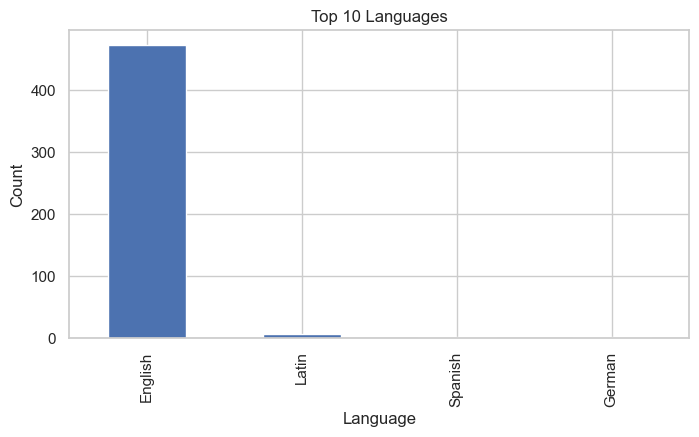

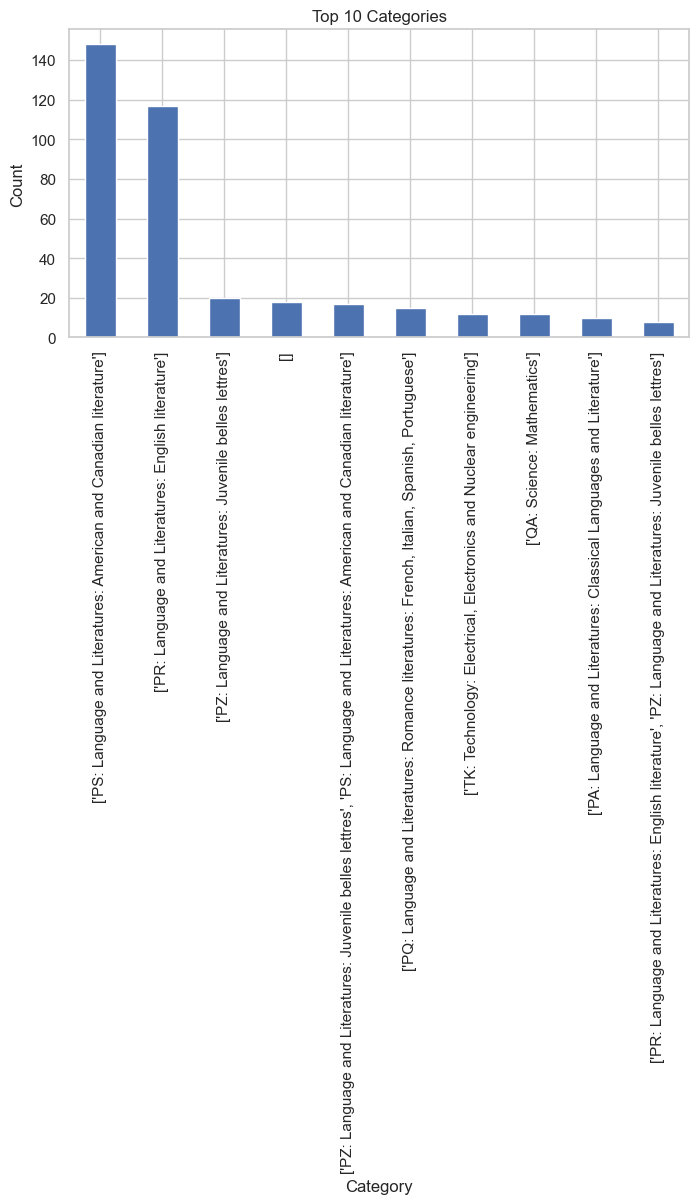

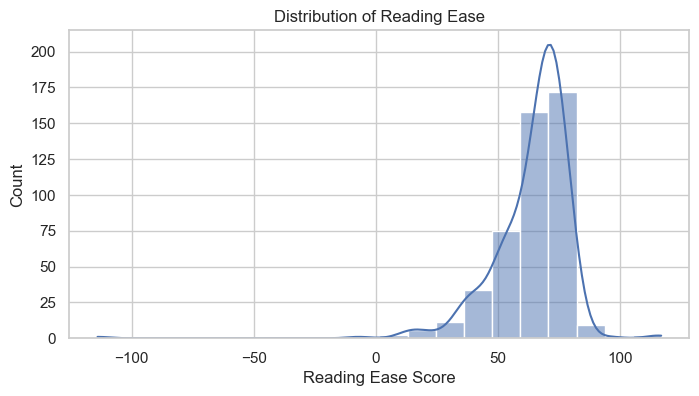

In [12]:
check_missing_values(df)
describe_data(df)
plot_top_languages(df)
plot_top_categories(df)
plot_reading_ease(df)


In [13]:


def remove_duplicates(df: pd.DataFrame) -> pd.DataFrame:
    """
    Remove duplicate rows from the dataset based on Title and Author/Language if available.

    Args:
        df (pd.DataFrame): Input DataFrame

    Returns:
        pd.DataFrame: Cleaned DataFrame without duplicates
    """
    # Count duplicates before removal
    duplicate_count = df.duplicated(subset=["Title", "Language"]).sum()
    print(f"🔎 Found {duplicate_count} duplicate rows.")

    # Remove duplicates (keep the first occurrence)
    df_cleaned = df.drop_duplicates(subset=["Title", "Language"], keep="first")

    print(f"✅ After removing duplicates: {len(df_cleaned)} rows remain.")
    return df_cleaned


In [14]:
df = remove_duplicates(df)

🔎 Found 24 duplicate rows.
✅ After removing duplicates: 476 rows remain.


In [17]:
def handle_missing_values(df: pd.DataFrame) -> pd.DataFrame:
    """
    Handle missing values in the dataset with appropriate strategies.

    Args:
        df (pd.DataFrame): Input DataFrame

    Returns:
        pd.DataFrame: Cleaned DataFrame
    """
    print("🔎 Missing values before cleaning:")
    print(df.isnull().sum())

    # 1. Drop rows where Title is missing → create a new copy
    df = df.dropna(subset=["Title"]).copy()

    # 2. Fill missing Language with "Unknown"
    df.loc[:, "Language"] = df["Language"].fillna("Unknown")

    # 3. Fill missing Release Date with "Unknown"
    df.loc[:, "Release Date"] = df["Release Date"].fillna("Unknown")

    # 4. Fill missing Reading Ease with mean
    mean_reading_ease = df["Reading Ease"].mean()
    df.loc[:, "Reading Ease"] = df["Reading Ease"].fillna(mean_reading_ease)

    print("\n✅ Missing values after cleaning:")
    print(df.isnull().sum())
    return df


In [18]:
df = handle_missing_values(df)


🔎 Missing values before cleaning:
ID              0
Title           0
Language        0
Release Date    0
Subjects        0
Categories      0
Reading Ease    0
dtype: int64

✅ Missing values after cleaning:
ID              0
Title           0
Language        0
Release Date    0
Subjects        0
Categories      0
Reading Ease    0
dtype: int64


In [ ]:
def feature_engineering(df):
    """Extract structured features like release year, encode language, and tokenize keywords."""
    df = df.copy()

    # --- Extract year from Release Date
    df["Release Year"] = df["Release Date"].str.extract(r"(\d{4})")
    df["Release Year"] = pd.to_numeric(df["Release Year"], errors="coerce").fillna(0).astype(int)

    # --- Encode Language
    df["Language"] = df["Language"].str.lower()
    df["Language_Code"] = df["Language"].astype("category").cat.codes

    # --- Clean Subjects & Categories
    def tokenize_keywords(text):
        if pd.isna(text):
            return []
        # Split by comma → lowercase → strip spaces
        return [kw.strip().lower() for kw in text.split(",")]

    df["Subjects"] = df["Subjects"].apply(tokenize_keywords)
    df["Categories"] = df["Categories"].apply(tokenize_keywords)

    return df


In [20]:
df = feature_engineering(df)
df.head(3)[["Title", "Release Date", "Release Year", "Language", "Subjects", "Categories"]]


,Title,Release Date,Release Year,Language,Subjects,Categories
0,The Declaration of Independence of the United ...,"Dec 1, 1971",1971,english,"[['United States -- History -- Revolution, 177...",[['E201: History: America: Revolution (1775-17...
1,The United States Bill of Rights The Ten Origi...,"Dec 1, 1972",1972,english,"[['Civil rights -- United States -- Sources', ...",[['JK: Political science: Political inst. and ...
2,John F. Kennedy's Inaugural Address,"Nov 1, 1973",1973,english,[['United States -- Foreign relations -- 1961-...,[['E838: History: America: Later twentieth cen...
